<a href="https://colab.research.google.com/github/YazCodes/ImagePrediction/blob/main/cat_or_dog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd

import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog

from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA

# library for evaluation
from sklearn import metrics

# libraries for ML algorithms
from sklearn import svm

In [2]:
# unzip data
with zipfile.ZipFile("/content/drive/MyDrive/data (1).zip", 'r') as zip_ref: 
    zip_ref.extractall("/content/")

In [3]:
# load training data
df_train = pd.read_csv("/content/data/train.csv")

#Load test data 
df_test = pd.read_csv("/content/data/test.csv")

# summarise the details
print(f'Number of entries: {len(df_train)}')
df_train.head()

Number of entries: 10000


,Id,Label
0,1,cat
1,2,dog
2,3,cat
3,4,cat
4,5,cat


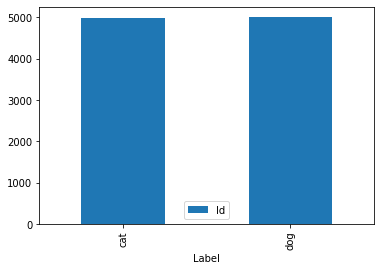

In [4]:
# Summarise label details in training data
temp_df = df_train.groupby('Label').count()
temp_df.plot.bar()

In [5]:
# method to load images
# parameters
# ids - list of image ids
# folder_path - path to image folder
# dim - dimensions to resize images
def load_images(ids, folder_path, dim):
  images = []
  for id in ids:
    image_path = os.path.join(folder_path, "{}.jpg".format(id))
    img = cv2.imread(image_path)

    # Resize if necessary  - only for the images where the width and height is not equal to the given dimentions 
    if img.shape[0] != dim[1] or img.shape[1] != dim[0]: #f not = 
      img = cv2.resize(img, dim) #then resize 
    images.append(img)
  return images #needs to be OUTSIDE the for loop 

In [6]:
base_dim = (200, 200) #width and height

# load train images
train_image_folder ="/content/data/train_images" #copy path from the folder 
train_images = load_images(df_train['Id'], train_image_folder, base_dim) # all the training folder images are loaded
print(f'Number of training images loaded: {len(train_images)}') #print out the lengh of train_image

# load test images
test_image_folder = "/content/data/test_images"
test_images = load_images(df_test['Id'], test_image_folder, base_dim)
print(f'Number of testing images loaded: {len(test_images)}')

Number of training images loaded: 10000
Number of testing images loaded: 1000


In [7]:
#Feature extraction 
# Feature extraction helps to get the best feature from those big data sets by select and combine variables into features, thus, effectively reducing the amount of data.
#without losing any important or relevant information

#Confusion Matrix 
#confusion matrix is a performance measurement technique for Machine learning classification. It is a kind of table which helps you to the know the performance of the classification model on a set of test data for that the true values are known.

# method to plot confusion matrix
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['dog', 'cat'] #Make sure the class names corrispond to the label names in the dataset colomn 
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

# method to calculate evaluation results
def evaluate(actuals, predictions):
  accuracy = metrics.accuracy_score(actuals, predictions)
  confusion_matrix = metrics.confusion_matrix(actuals, predictions, labels=['dog', 'cat']) #Make sure the labels corrispond to the label names in the dataset colomn 
  return accuracy, confusion_matrix

  #same as sentiment analysis 

In [8]:
#SVM
# method to train and predict using SVM classifier
def get_svm_predictions(X_train, X_val, y_train, y_val):
  # build model
  clf = svm.SVC(kernel='linear', random_state=100) 
  clf.fit(X_train, y_train)

  # Make predictions on test data
  y_pred = clf.predict(X_val)

  # evaluation
  accuracy, confusion_matrix = evaluate(y_val, y_pred)
  print(f'Accuracy: {accuracy}')
  plot_confusion_matrix(confusion_matrix)

  return clf

In [9]:
#Model One

#Model one - have to do preprocessing and feature extracyion on every image - created a function 
# method to get image features
def get_features_m1(images):
  features_list = []
  for img in images:
    # image preprocessing
    img_grayscaled = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # vectorise/ feature extraction
    features = img_grayscaled.flatten()

    features_list.append(features)

  features_list = np.array(features_list)
  return features_list

(10000, 40000)
Accuracy: 0.516


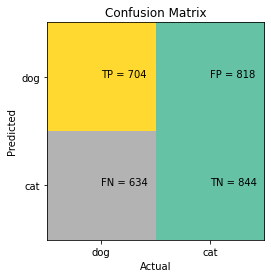

In [10]:
# feature extraction
features_train = get_features_m1(train_images)
print(features_train.shape)

# data split for train and validation
X_train, X_val, y_train, y_val = train_test_split(features_train, df_train['Label'], test_size=0.3, random_state=100)

# train and validation
model = get_svm_predictions(X_train, X_val, y_train, y_val)



In [ ]:
# feature extraction - test data
features_test = get_features_m1(test_images)
print(features_test.shape)

# get model predictions
predictions = model.predict(features_test)
print(predictions) 

df_test["Label"] - predictions #Adding the predictions to the label column 

## save data frame to .csv file
df_test.to_csv('/content/test-predictions.csv', index=False)